Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (506, 14)

Missing values per column:
CRIM       20
ZN         20
INDUS      20
CHAS       20
LSTAT      20
AGE        20
RM          0
NOX         0
RAD         0
DIS         0
TAX         0
PTRATIO     0
B           0
MEDV        0
dtype: int64


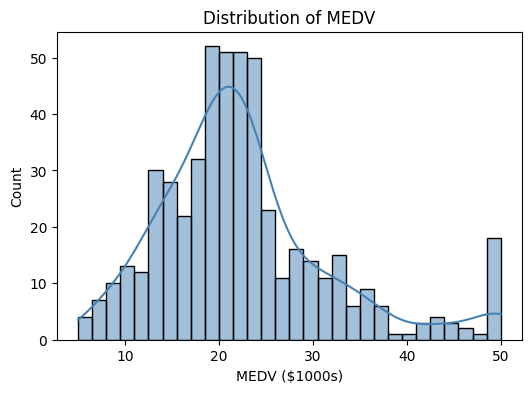

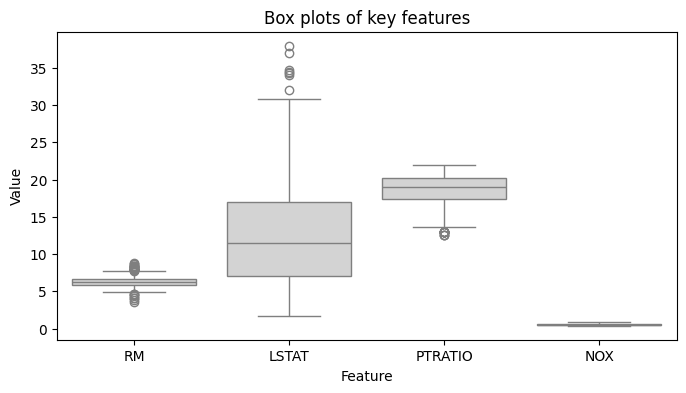

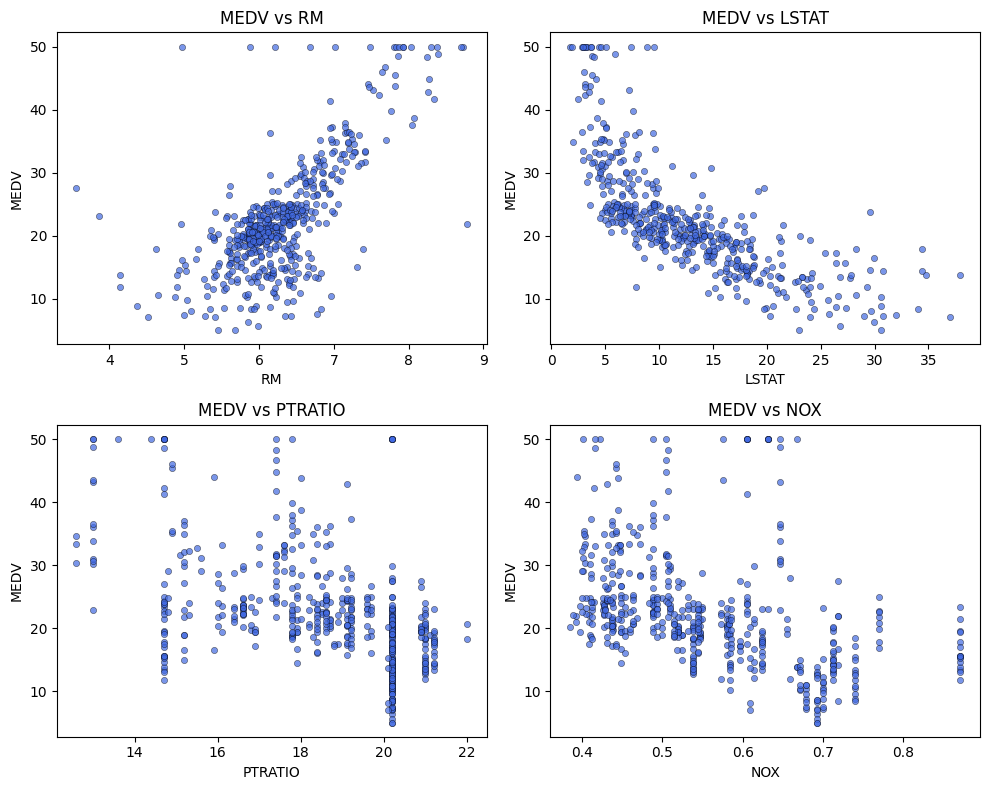


Correlations with MEDV:
LSTAT     -0.735822
RM         0.695360
PTRATIO   -0.507787
NOX       -0.427321
Name: MEDV, dtype: float64

Simple Linear Regression (one feature)
Feature used = LSTAT
R^2 on test = 0.5514
MSE on test = 32.8976

Multiple regression models on test set
OLS Regression R^2 score: 0.6593
OLS Regression MSE: 24.9834

Linear Regression R^2 score: 0.6593
Linear Regression MSE: 24.9834

Ridge Regression R^2 score: 0.6587
Ridge Regression MSE: 25.0309

Lasso Regression R^2 score: 0.6593
Lasso Regression MSE: 24.9838

Chosen alpha for Ridge = 10.0
Chosen alpha for Lasso = 0.0001


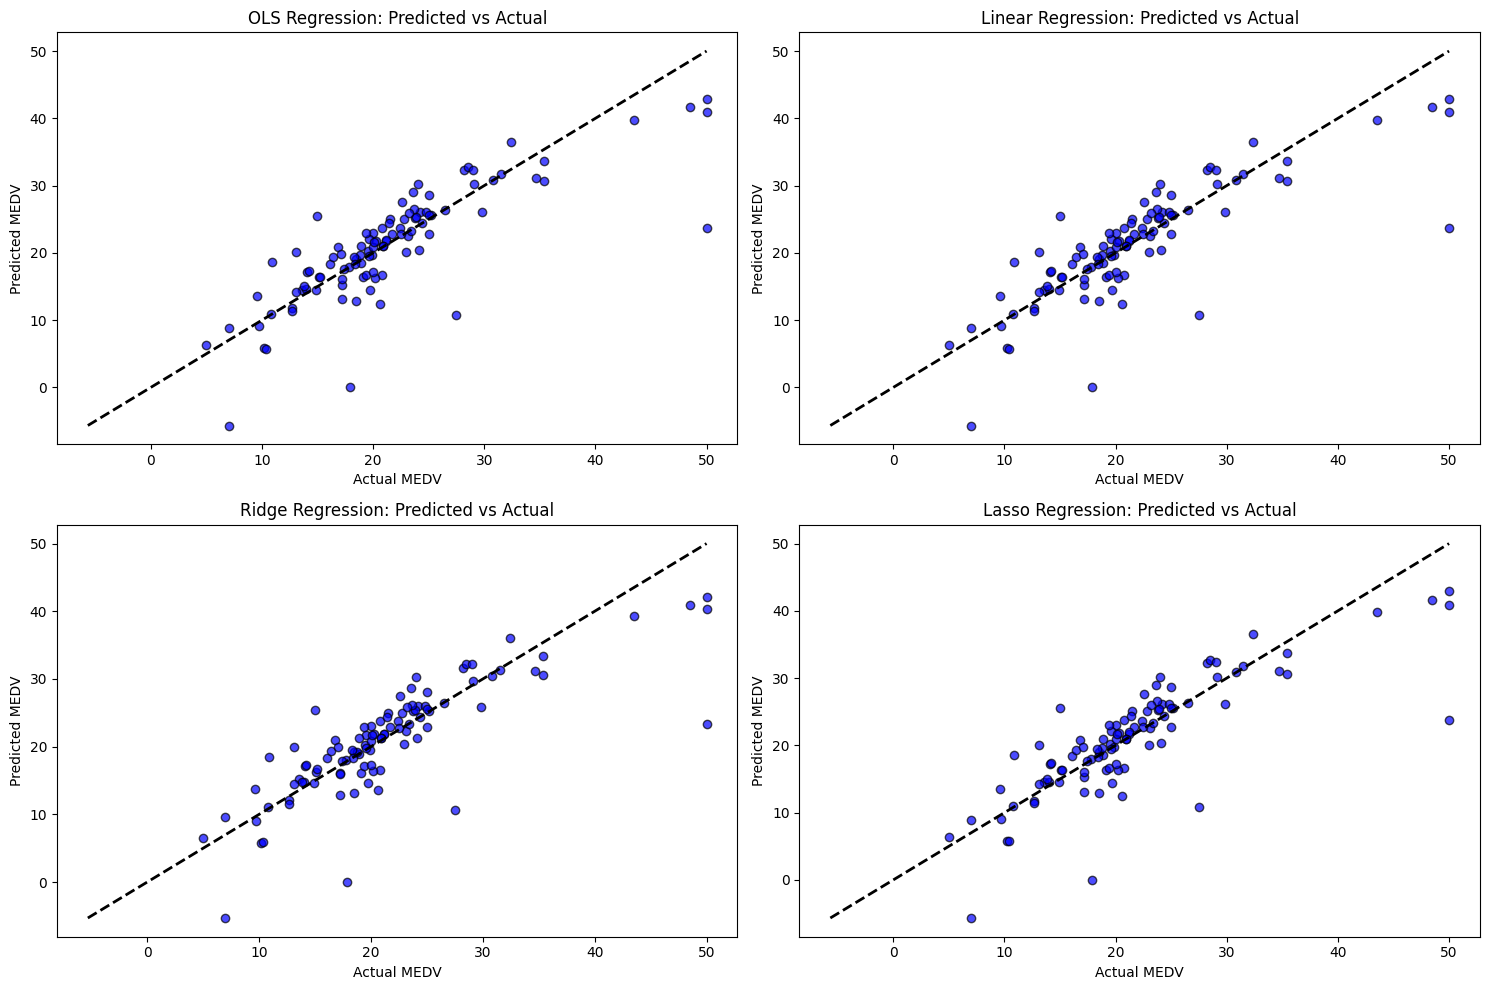

In [ ]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# -------------------------
# Task 1. Load and EDA
# -------------------------
drive.mount('/content/drive')

# Load the file from Drive
csv_path = '/content/drive/MyDrive/Assignment /HousingData.csv'  # note the space
df = pd.read_csv(csv_path, na_values=['NA', 'NaN', ''], skipinitialspace=True)
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

# Target
target = 'MEDV'  # provided file uses MEDV as target

# Histogram of target
plt.figure(figsize=(6, 4))
sns.histplot(df[target], kde=True, bins=30, color='steelblue')
plt.title('Distribution of MEDV')
plt.xlabel('MEDV ($1000s)')
plt.ylabel('Count')
plt.show()

# Box plots for key predictors
key_feats = ['RM', 'LSTAT', 'PTRATIO', 'NOX']
df_melt = df.melt(value_vars=key_feats, var_name='feature', value_name='value')
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_melt, x='feature', y='value', color='lightgray')
plt.title('Box plots of key features')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

# Scatter plots: MEDV vs key features
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.ravel(), key_feats):
    sns.scatterplot(x=df[col], y=df[target], ax=ax, color='royalblue', edgecolor='k', s=20, alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel('MEDV')
    ax.set_title(f'MEDV vs {col}')
plt.tight_layout()
plt.show()

# Correlations with MEDV
corrs = df[key_feats + [target]].corr().loc[target].drop(target).sort_values(key=lambda s: s.abs(), ascending=False)
print("\nCorrelations with MEDV:")
print(corrs)

# -------------------------
# Preprocessing
# -------------------------
X_full = df.drop(columns=[target])
y = df[target].astype(float).values

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Scale for sklearn models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

# -------------------------
# Task 2. Simple linear regression
# -------------------------
# Choose a strong single feature from TRAIN correlations to avoid peeking at the test set
train_df = pd.DataFrame(X_train, columns=X_full.columns)
train_df[target] = y_train
train_corrs = train_df.corr(numeric_only=True)[target].drop(target).sort_values(key=lambda s: s.abs(), ascending=False)
simple_feature = train_corrs.index[0]  # typically 'LSTAT' or 'RM'

Xi_train = X_train[[simple_feature]]
Xi_test  = X_test[[simple_feature]]

Xi_train_imp = imputer.fit_transform(Xi_train)
Xi_test_imp  = imputer.transform(Xi_test)

sc_simple = StandardScaler()
Xi_train_sc = sc_simple.fit_transform(Xi_train_imp)
Xi_test_sc  = sc_simple.transform(Xi_test_imp)

lin_simple = LinearRegression().fit(Xi_train_sc, y_train)
y_pred_simple = lin_simple.predict(Xi_test_sc)

print("\nSimple Linear Regression (one feature)")
print(f"Feature used = {simple_feature}")
print(f"R^2 on test = {r2_score(y_test, y_pred_simple):.4f}")
print(f"MSE on test = {mean_squared_error(y_test, y_pred_simple):.4f}\n")

# -------------------------
# Task 2. Multiple regression models
# -------------------------
# OLS on imputed unscaled X with intercept
X_ols_train = sm.add_constant(X_train_imp)
X_ols_test  = sm.add_constant(X_test_imp)
ols_model   = sm.OLS(y_train, X_ols_train).fit()
y_pred_ols  = ols_model.predict(X_ols_test)

# Linear, RidgeCV, LassoCV on scaled X
linear_model = LinearRegression().fit(X_train_scaled, y_train)
ridge_cv     = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0]).fit(X_train_scaled, y_train)
lasso_cv     = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0], max_iter=100000, cv=5, random_state=42).fit(X_train_scaled, y_train)

y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_ridge  = ridge_cv.predict(X_test_scaled)
y_pred_lasso  = lasso_cv.predict(X_test_scaled)

# Metrics
def report(name, y_true, y_pred):
    print(f"{name} Regression R^2 score: {r2_score(y_true, y_pred):.4f}")
    print(f"{name} Regression MSE: {mean_squared_error(y_true, y_pred):.4f}\n")

print("Multiple regression models on test set")
for name, yhat in [
    ("OLS", y_pred_ols),
    ("Linear", y_pred_linear),
    ("Ridge", y_pred_ridge),
    ("Lasso", y_pred_lasso),
]:
    report(name, y_test, yhat)

print(f"Chosen alpha for Ridge = {ridge_cv.alpha_}")
print(f"Chosen alpha for Lasso = {lasso_cv.alpha_}")

# Predicted vs Actual plots for multiple models
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
models = ['OLS', 'Linear', 'Ridge', 'Lasso']
preds  = [y_pred_ols, y_pred_linear, y_pred_ridge, y_pred_lasso]

for i, (name, y_pred) in enumerate(zip(models, preds)):
    axs[i].scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
    lo = min(y_test.min(), y_pred.min())
    hi = max(y_test.max(), y_pred.max())
    axs[i].plot([lo, hi], [lo, hi], 'k--', lw=2)
    axs[i].set_xlabel('Actual MEDV')
    axs[i].set_ylabel('Predicted MEDV')
    axs[i].set_title(f'{name} Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model performance on the test set
OLS Regression R^2 on test = 0.9044
OLS Regression MSE on test = 12829.1605

Linear Regression R^2 on test = 0.9044
Linear Regression MSE on test = 12829.1605

Ridge Regression R^2 on test = 0.8980
Ridge Regression MSE on test = 13697.6069

Lasso Regression R^2 on test = 0.8985
Lasso Regression MSE on test = 13629.0420

Task 1 — OLS Least Squares Estimates
               coef    std_err
const   -502.160838  34.317312
Length1   64.156366  46.105116
Length2  -20.526823  48.523725
Length3  -17.318744  19.502112
Height    20.920713  10.086845
Width     33.883756  22.726018

Train R^2 = 0.8786

Task 2 — Ridge
Chosen alpha = 10.0
const     -501.575345
Length1      8.371587
Length2      7.391914
Length3      5.762505
Height       8.742002
Width       47.221564
dtype: float64

Task 2 — Lasso
Chosen alpha = 1.0
const     -511.740021
L

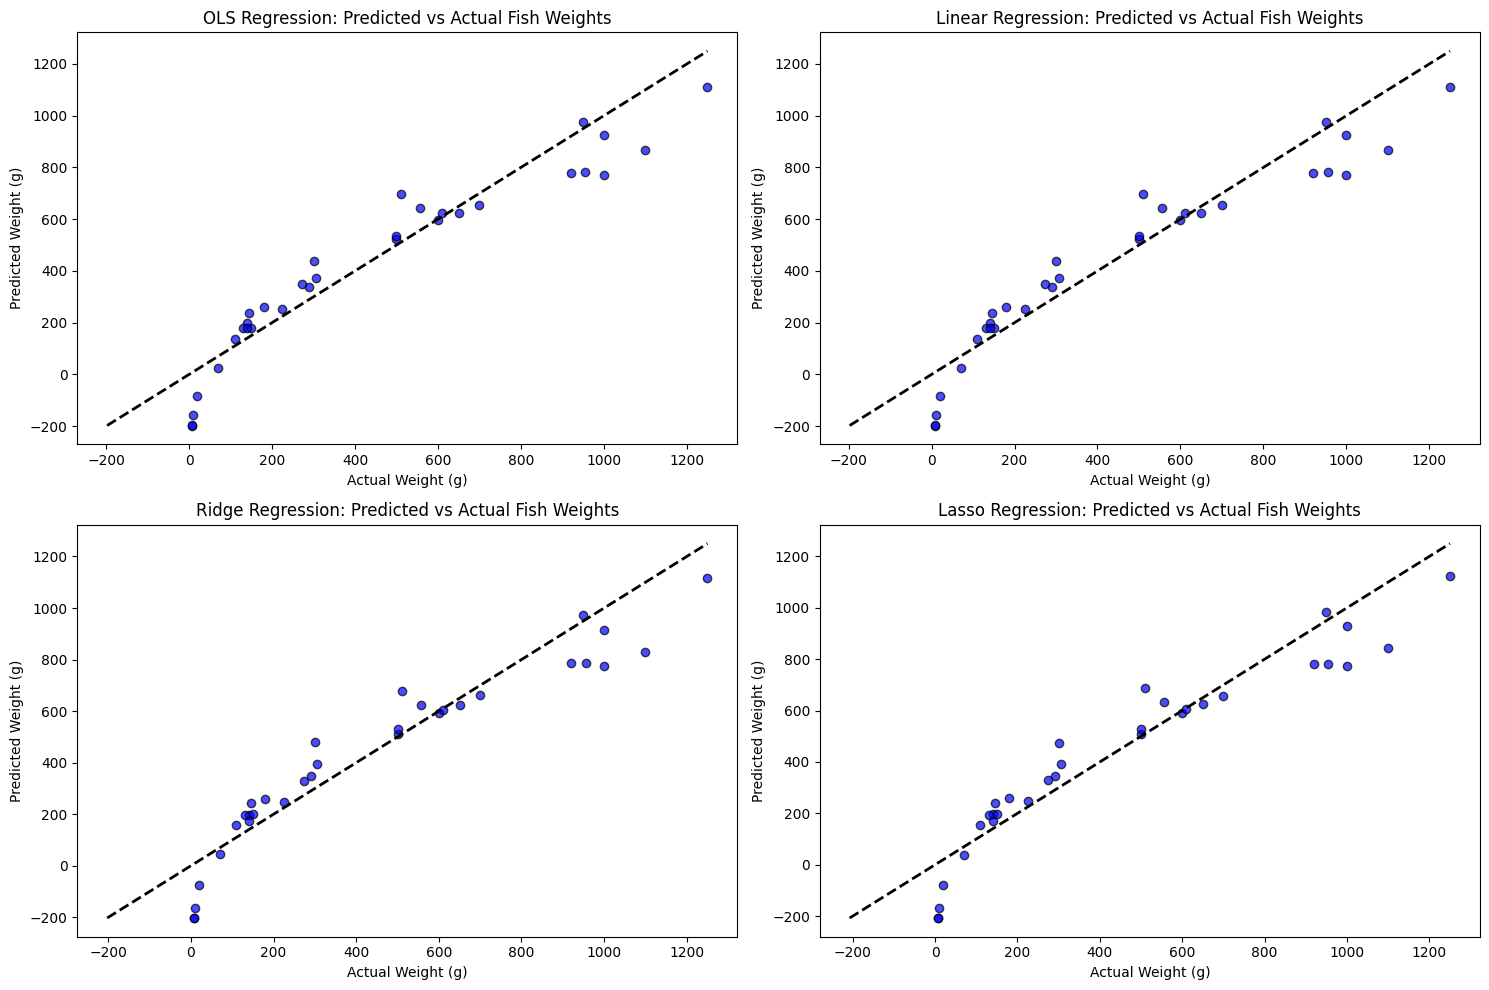

In [4]:
# Fish regression using the professor template

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import statsmodels.api as sm

# 1) Mount and load
drive.mount('/content/drive')  # ignore the message if already mounted
csv_path = '/content/drive/MyDrive/Assignment /Fish.csv'  # note the space in 'Assignment '

# Read and clean
df = pd.read_csv(csv_path, skipinitialspace=True)
df.columns = df.columns.str.strip()

# Keep only valid target and the five geometric predictors
features = ['Length1','Length2','Length3','Height','Width']
target = 'Weight'

df = df[df[target].notna()].copy()
df = df[df[target] > 0].copy()
df = df.dropna(subset=features).copy()

X_df = df[features].copy()
y = df[target].to_numpy()
X = X_df.to_numpy()
feature_names = X_df.columns.tolist()

# 2) Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Scale for sklearn models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4) OLS on unscaled X with intercept
X_ols_train = sm.add_constant(X_train)
X_ols_test  = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_ols_train).fit()
y_pred_ols = ols_model.predict(X_ols_test)

# 5) Linear, RidgeCV, LassoCV on scaled X
linear_model = LinearRegression().fit(X_train_scaled, y_train)
ridge_cv     = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0]).fit(X_train_scaled, y_train)
lasso_cv     = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0], max_iter=100000, cv=5, random_state=42).fit(X_train_scaled, y_train)

y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_ridge  = ridge_cv.predict(X_test_scaled)
y_pred_lasso  = lasso_cv.predict(X_test_scaled)

# 6) Model performance on test set
def report_metrics(name, y_true, y_pred):
    print(f"{name} Regression R^2 on test = {r2_score(y_true, y_pred):.4f}")
    print(f"{name} Regression MSE on test = {mean_squared_error(y_true, y_pred):.4f}\n")

print("Model performance on the test set")
report_metrics("OLS",    y_test, y_pred_ols)
report_metrics("Linear", y_test, y_pred_linear)
report_metrics("Ridge",  y_test, y_pred_ridge)
report_metrics("Lasso",  y_test, y_pred_lasso)

# 7) Task 1 — OLS coefficients and standard errors
print("Task 1 — OLS Least Squares Estimates")
ols_table = pd.DataFrame({
    "coef": ols_model.params,
    "std_err": ols_model.bse
}, index=["const", *feature_names])
print(ols_table)
print(f"\nTrain R^2 = {ols_model.rsquared:.4f}\n")

# 8) Task 2 — Ridge and Lasso coefficients in original units
# Back-transform from standardized X to original feature units
mu = scaler.mean_
sigma = scaler.scale_

def back_transform(intercept_std, coef_std, mu, sigma):
    beta_orig = coef_std / sigma
    intercept_orig = intercept_std - np.sum(coef_std * mu / sigma)
    return intercept_orig, beta_orig

ridge_intercept_orig, ridge_beta_orig = back_transform(ridge_cv.intercept_, ridge_cv.coef_, mu, sigma)
lasso_intercept_orig, lasso_beta_orig = back_transform(lasso_cv.intercept_, lasso_cv.coef_, mu, sigma)

print("Task 2 — Ridge")
print(f"Chosen alpha = {ridge_cv.alpha_}")
print(pd.Series([ridge_intercept_orig, *ridge_beta_orig], index=['const', *feature_names]))
print()

print("Task 2 — Lasso")
print(f"Chosen alpha = {lasso_cv.alpha_}")
print(pd.Series([lasso_intercept_orig, *lasso_beta_orig], index=['const', *feature_names]))
print()

# 9) Task 2 — Bootstrap standard errors for Ridge and Lasso coefficients
def bootstrap_coef_se(X_all, y_all, alpha_ridge, alpha_lasso, B=500, random_state=42):
    rng = np.random.RandomState(random_state)
    ridge_coefs = []
    lasso_coefs = []
    n = len(y_all)
    for _ in range(B):
        idx = rng.randint(0, n, n)
        Xb, yb = X_all[idx], y_all[idx]
        Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb, yb, test_size=0.2, random_state=42)
        sc = StandardScaler()
        Xb_tr_sc = sc.fit_transform(Xb_tr)

        r = Ridge(alpha=alpha_ridge).fit(Xb_tr_sc, yb_tr)
        l = Lasso(alpha=alpha_lasso, max_iter=100000).fit(Xb_tr_sc, yb_tr)

        mu_b, sigma_b = sc.mean_, sc.scale_
        def back_t(intc, coef):
            beta = coef / sigma_b
            c0 = intc - np.sum(coef * mu_b / sigma_b)
            return np.r_[c0, beta]

        ridge_coefs.append(back_t(r.intercept_, r.coef_))
        lasso_coefs.append(back_t(l.intercept_, l.coef_))

    ridge_arr = np.vstack(ridge_coefs)
    lasso_arr = np.vstack(lasso_coefs)
    ridge_se = ridge_arr.std(axis=0, ddof=1)
    lasso_se = lossa_arr.std(axis=0, ddof=1)  # <-- typo fixed below

# Fix small typo and print SEs
def bootstrap_coef_se(X_all, y_all, alpha_ridge, alpha_lasso, B=500, random_state=42):
    rng = np.random.RandomState(random_state)
    ridge_coefs = []
    lasso_coefs = []
    n = len(y_all)
    for _ in range(B):
        idx = rng.randint(0, n, n)
        Xb, yb = X_all[idx], y_all[idx]
        Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb, yb, test_size=0.2, random_state=42)
        sc = StandardScaler()
        Xb_tr_sc = sc.fit_transform(Xb_tr)

        r = Ridge(alpha=alpha_ridge).fit(Xb_tr_sc, yb_tr)
        l = Lasso(alpha=alpha_lasso, max_iter=100000).fit(Xb_tr_sc, yb_tr)

        mu_b, sigma_b = sc.mean_, sc.scale_
        def back_t(intc, coef):
            beta = coef / sigma_b
            c0 = intc - np.sum(coef * mu_b / sigma_b)
            return np.r_[c0, beta]

        ridge_coefs.append(back_t(r.intercept_, r.coef_))
        lasso_coefs.append(back_t(l.intercept_, l.coef_))

    ridge_arr = np.vstack(ridge_coefs)
    lasso_arr = np.vstack(lasso_coefs)
    ridge_se = ridge_arr.std(axis=0, ddof=1)
    lasso_se = lasso_arr.std(axis=0, ddof=1)
    names = ['const', *feature_names]
    return pd.Series(ridge_se, index=names), pd.Series(lasso_se, index=names)

ridge_se, lasso_se = bootstrap_coef_se(X, y, ridge_cv.alpha_, lasso_cv.alpha_, B=500, random_state=42)
print("Bootstrap standard errors — Ridge")
print(ridge_se)
print("\nBootstrap standard errors — Lasso")
print(lasso_se)
print()

# 10) Plots like the template
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
models = ['OLS', 'Linear', 'Ridge', 'Lasso']
preds  = [y_pred_ols, y_pred_linear, y_pred_ridge, y_pred_lasso]

for i, (name, y_pred) in enumerate(zip(models, preds)):
    axs[i].scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
    lo = min(y_test.min(), y_pred.min())
    hi = max(y_test.max(), y_pred.max())
    axs[i].plot([lo, hi], [lo, hi], 'k--', lw=2)
    axs[i].set_xlabel('Actual Weight (g)')
    axs[i].set_ylabel('Predicted Weight (g)')
    axs[i].set_title(f'{name} Regression: Predicted vs Actual Fish Weights')

plt.tight_layout()
plt.show()
